<a href="https://colab.research.google.com/github/TRSTRSTRS/Programming-Assignment-2-Lexical-Scoping-/blob/master/Desastres_RS_TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CÓDIGO FINAL APLICADO AO TCC DE LRS PARA APRESENTAÇÃO AO MBA DE NEGÓCIOS E FINANÇAS

Total de eventos válidos (linhas de sinistro): 1,655

--- Severidade Observada (S - evento unitário) ---
Média:         R$ 5,642,838.12
Mediana:       R$ 1,875,956.82
Desvio Padrão: R$ 30,907,290.44
VaR 90:        R$ 9,268,423.52
VaR 95:        R$ 13,339,388.14
VaR 99,5:      R$ 88,618,946.31
Máx. amostra:  R$ 870,827,000.00

Parâmetros de Severidade ajustados:
  Lognormal -> mu=14.009983, sigma=2.077939
  Lomax     -> alpha=1.473319, theta=2,772,190.53

--- Severidade simulada Lognormal (S) ---
Média:         R$ 10,399,736.34
Mediana:       R$ 1,207,954.82
Desvio Padrão: R$ 76,115,725.96
VaR 90:        R$ 17,489,825.15
VaR 95:        R$ 37,246,775.82
VaR 99,5:      R$ 254,143,922.96
Máx. amostra:  R$ 14,930,070,741.42

--- Severidade simulada Lomax (S) ---
Média:         R$ 5,601,719.14
Mediana:       R$ 1,654,183.00
Desvio Padrão: R$ 38,920,480.79
VaR 90:        R$ 10,380,788.89
VaR 95:        R$ 18,149,995.05
VaR 99,5:      R$ 94,986,313.42
Máx. amostra:  R$ 6,810,215,955.30


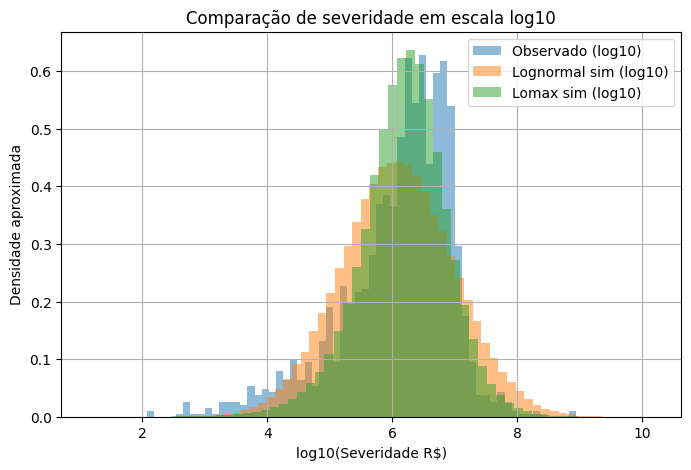


Parâmetros de Frequência ajustados:
  Média observada F: 150.45
  Variância observada F: 16159.07
  Poisson -> lambda=150.454545
  NegBin  -> r=1.414024, p=0.009311

--- Frequência Observada (F - eventos/ano) ---
Média:         R$ 150.45
Mediana:       R$ 70.00
Desvio Padrão: R$ 127.12
VaR 90:        R$ 308.00
VaR 95:        R$ 371.50
VaR 99,5:      R$ 428.65
Máx. amostra:  R$ 435.00

--- Frequência simulada NegBin (F) ---
Média:         R$ 150.70
Mediana:       R$ 117.00
Desvio Padrão: R$ 127.17
VaR 90:        R$ 319.00
VaR 95:        R$ 402.00
VaR 99,5:      R$ 667.00
Máx. amostra:  R$ 1,441.00


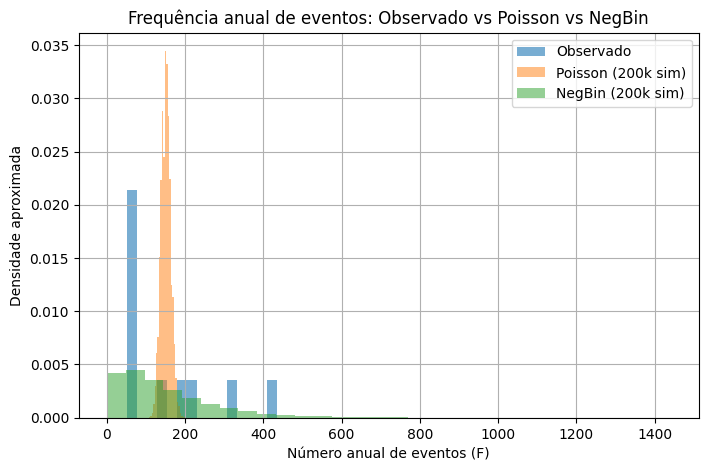


Limites (caps) aplicados com base no VaR 99,5% observado:
  Cap de severidade S_cap = R$ 88,618,946.31
  Cap de frequência F_cap = 429 eventos/ano

--- Perda Anual Simulada - COM limites (modelo final) ---
Média:         R$ 692,019,712.88
Mediana:       R$ 550,319,597.65
Desvio Padrão: R$ 545,192,856.73
VaR 90:        R$ 1,528,424,734.14
VaR 95:        R$ 1,852,025,692.12
VaR 99,5:      R$ 2,305,219,818.06
TVaR 99,5:     R$ 2,411,387,001.31
Máx. amostra:  R$ 3,016,924,867.47


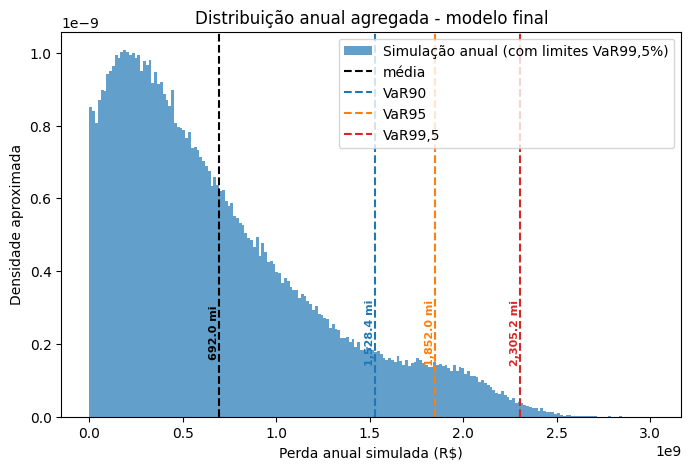


=== Exposição Máxima ao Risco (EMR) ===
VaR 99,5% (P): R$ 2,305,219,818.06
Média E[P]:    R$ 692,019,712.88
EMR:           R$ 1,613,200,105.18

=== TVaR 99,5% para referência ===
TVaR 99,5% (P): R$ 2,411,387,001.31


In [4]:
# ============================================================
# BLOCO 0 - Imports e setup
# ============================================================

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True  # grade default para gráficos intermediários


# ============================================================
# Funções utilitárias
# ============================================================

def var_func(x, q):
    return np.percentile(x, q)

def tvar_func(x, q):
    v = var_func(x, q)
    return x[x >= v].mean()

def describe_sample(sample, label="", include_tvar=False):
    arr = np.array(sample, dtype=float)
    print(f"\n--- {label} ---")
    print(f"Média:         R$ {np.mean(arr):,.2f}")
    print(f"Mediana:       R$ {np.median(arr):,.2f}")
    print(f"Desvio Padrão: R$ {np.std(arr, ddof=1):,.2f}")
    print(f"VaR 90:        R$ {var_func(arr,90):,.2f}")
    print(f"VaR 95:        R$ {var_func(arr,95):,.2f}")
    print(f"VaR 99,5:      R$ {var_func(arr,99.5):,.2f}")
    if include_tvar:
        print(f"TVaR 99,5:     R$ {tvar_func(arr,99.5):,.2f}")
    print(f"Máx. amostra:  R$ {np.max(arr):,.2f}")


# ============================================================
# BLOCO 1 - Carregar base e preparar dados
# ============================================================

path = "/content/Base_Dados_Analitico.xlsx"  # ajuste se necessário no Colab
df = pd.read_excel(path)

# padroniza nomes das colunas
df.columns = [c.lower().strip() for c in df.columns]

# identifica colunas relevantes
col_valor = [c for c in df.columns if "valor" in c and "dano" in c][0]
col_data = [c for c in df.columns if "data" in c][0]
col_protocolo = [c for c in df.columns if "protocolo" in c][0]

# normaliza data e ano
df[col_data] = pd.to_datetime(df[col_data], errors='coerce')
df["ano"] = df[col_data].dt.year

# mantém apenas registros válidos
df = df[df["ano"].notna()].copy()

# severidade observada de cada evento (S)
severity_obs = df[col_valor].astype(float)
severity_obs = severity_obs[severity_obs > 0].copy()

# frequência anual observada (F): nº de protocolos únicos por ano
freq_anuais = (
    df.groupby("ano")[col_protocolo]
      .nunique()
      .reset_index()
      .rename(columns={col_protocolo: "qtd_eventos"})
      .sort_values("ano")
)
freq_obs = freq_anuais["qtd_eventos"].values

print(f"Total de eventos válidos (linhas de sinistro): {len(severity_obs):,}")
describe_sample(severity_obs, "Severidade Observada (S - evento unitário)")


# ============================================================
# BLOCO 2 - Ajuste de Severidade (Lognormal x Lomax)
# ============================================================

# Ajuste Lognormal (loc=0)
shape_logn, loc_logn, scale_logn = st.lognorm.fit(severity_obs, floc=0)
mu_hat = np.log(scale_logn)
sigma_hat = shape_logn

# Ajuste Lomax (Pareto Tipo II) (loc=0)
alpha_hat, loc_lomax, scale_lomax = st.lomax.fit(severity_obs, floc=0)

print("\nParâmetros de Severidade ajustados:")
print(f"  Lognormal -> mu={mu_hat:.6f}, sigma={sigma_hat:.6f}")
print(f"  Lomax     -> alpha={alpha_hat:.6f}, theta={scale_lomax:,.2f}")

# Simulações de severidade para comparação
rng = np.random.default_rng(123)
sim_logn = st.lognorm.rvs(sigma_hat, 0, np.exp(mu_hat), size=200_000, random_state=rng)
sim_lomax = st.lomax.rvs(alpha_hat, 0, scale_lomax, size=200_000, random_state=rng)

describe_sample(sim_logn,  "Severidade simulada Lognormal (S)")
describe_sample(sim_lomax, "Severidade simulada Lomax (S)")

# -------- Gráfico de aderência da severidade (escala log10) --------
plt.figure(figsize=(8,5))
plt.hist(np.log10(severity_obs), bins=60, density=True, alpha=0.5, label="Observado (log10)")
plt.hist(np.log10(sim_logn),     bins=60, density=True, alpha=0.5, label="Lognormal sim (log10)")
plt.hist(np.log10(sim_lomax),    bins=60, density=True, alpha=0.5, label="Lomax sim (log10)")

plt.xlabel("log10(Severidade R$)")
plt.ylabel("Densidade aproximada")
plt.title("Comparação de severidade em escala log10")
plt.legend()
plt.grid(True)
plt.show()


# ============================================================
# BLOCO 3 - Ajuste de Frequência (Poisson x Binomial Negativa)
# ============================================================

mean_freq = freq_obs.mean()
var_freq  = freq_obs.var(ddof=1)

# Poisson
lambda_hat = mean_freq

# Binomial Negativa (método dos momentos)
if var_freq > mean_freq:
    r_hat = mean_freq**2 / (var_freq - mean_freq)
    p_hat = r_hat / (r_hat + mean_freq)
else:
    r_hat = np.inf
    p_hat = 1.0

print("\nParâmetros de Frequência ajustados:")
print(f"  Média observada F: {mean_freq:.2f}")
print(f"  Variância observada F: {var_freq:.2f}")
print(f"  Poisson -> lambda={lambda_hat:.6f}")
print(f"  NegBin  -> r={r_hat:.6f}, p={p_hat:.6f}")

# simulação de frequência para comparação visual
rng = np.random.default_rng(321)
sim_freq_poisson = st.poisson.rvs(lambda_hat, size=200_000, random_state=rng)
sim_freq_nb      = st.nbinom.rvs(r_hat, p_hat, size=200_000, random_state=rng)

describe_sample(freq_obs,          "Frequência Observada (F - eventos/ano)")
describe_sample(sim_freq_nb,       "Frequência simulada NegBin (F)")

# -------- Gráfico de aderência da frequência --------
plt.figure(figsize=(8,5))
plt.hist(freq_obs,          bins=15,  density=True, alpha=0.6, label="Observado")
plt.hist(sim_freq_poisson,  bins=30,  density=True, alpha=0.5, label="Poisson (200k sim)")
plt.hist(sim_freq_nb,       bins=30,  density=True, alpha=0.5, label="NegBin (200k sim)")

plt.xlabel("Número anual de eventos (F)")
plt.ylabel("Densidade aproximada")
plt.title("Frequência anual de eventos: Observado vs Poisson vs NegBin")
plt.legend()
plt.grid(True)
plt.show()


# ============================================================
# BLOCO 4 - Definir travas (caps) usando VaR 99,5% observado
# ============================================================

sev_cap = var_func(severity_obs, 99.5)   # cap por severidade S
freq_cap = var_func(freq_obs, 99.5)      # cap por frequência F

print("\nLimites (caps) aplicados com base no VaR 99,5% observado:")
print(f"  Cap de severidade S_cap = R$ {sev_cap:,.2f}")
print(f"  Cap de frequência F_cap = {freq_cap:,.0f} eventos/ano")


# ============================================================
# BLOCO 5 - Simulação agregada anual (Monte Carlo, 200k cenários)
# ============================================================

def simulate_one_year_loss(r, p, alpha, theta, rng, sev_cap, freq_cap):
    # sortear F ~ NegBin
    F = st.nbinom.rvs(r, p, random_state=rng)
    # aplicar cap de frequência
    F = min(F, int(freq_cap))
    if F <= 0:
        return 0.0
    # sortear severidades S_i ~ Lomax
    S = st.lomax.rvs(alpha, 0, theta, size=F, random_state=rng)
    # aplicar cap de severidade
    S = np.minimum(S, sev_cap)
    # perda anual agregada P = soma(S_i)
    return S.sum()

rng = np.random.default_rng(2025)
annual_losses = np.array([
    simulate_one_year_loss(r_hat, p_hat,
                           alpha_hat, scale_lomax,
                           rng,
                           sev_cap=sev_cap,
                           freq_cap=freq_cap)
    for _ in range(200_000)
])

describe_sample(
    annual_losses,
    "Perda Anual Simulada - COM limites (modelo final)",
    include_tvar=True
)

# guardar métricas principais para plot e para EMR
mean_P    = np.mean(annual_losses)
VaR90_P   = var_func(annual_losses,90)
VaR95_P   = var_func(annual_losses,95)
VaR995_P  = var_func(annual_losses,99.5)
TVaR995_P = tvar_func(annual_losses,99.5)


# ============================================================
# BLOCO 6 - Gráfico final da perda anual agregada
# ============================================================

plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(
    annual_losses,
    bins=200,
    alpha=0.7,
    density=True,
    label="Simulação anual (com limites VaR99,5%)"
)

# linhas verticais
plt.axvline(mean_P,   color="black",      linestyle="--", linewidth=1.5, label="média")
plt.axvline(VaR90_P,  color="tab:blue",   linestyle="--", linewidth=1.5, label="VaR90")
plt.axvline(VaR95_P,  color="tab:orange", linestyle="--", linewidth=1.5, label="VaR95")
plt.axvline(VaR995_P, color="tab:red",    linestyle="--", linewidth=1.5, label="VaR99,5")

# posição dos textos em milhões
y_min, y_max = plt.ylim()
y_text = y_max * 0.22

def annotate_in_millions(x_value, color):
    plt.text(
        x_value,
        y_text,
        f"{x_value/1e6:,.1f} mi",
        color=color,
        ha="center",
        va="bottom",
        rotation=90,
        rotation_mode="anchor",
        fontsize=8,
        fontweight="bold"
    )

annotate_in_millions(mean_P,   "black")
annotate_in_millions(VaR90_P,  "tab:blue")
annotate_in_millions(VaR95_P,  "tab:orange")
annotate_in_millions(VaR995_P, "tab:red")

plt.xlabel("Perda anual simulada (R$)")
plt.ylabel("Densidade aproximada")
plt.title("Distribuição anual agregada - modelo final")
plt.legend()
plt.grid(False)  # gráfico final sem grade, como combinamos
plt.show()


# ============================================================
# BLOCO 7 - Cálculo da EMR (Exposição Máxima ao Risco)
# ============================================================

EMR = VaR995_P - mean_P
print("\n=== Exposição Máxima ao Risco (EMR) ===")
print(f"VaR 99,5% (P): R$ {VaR995_P:,.2f}")
print(f"Média E[P]:    R$ {mean_P:,.2f}")
print(f"EMR:           R$ {EMR:,.2f}")

print("\n=== TVaR 99,5% para referência ===")
print(f"TVaR 99,5% (P): R$ {TVaR995_P:,.2f}")
